In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pyemma
import seaborn as sns
import scipy
import mdtraj as md
import sys

sys.path.insert(1, "../../python/")
from util import *
from plotting import *

# Hydrophobic plug

inspired by analysis of F223 rotamers in Schwaiger PLOS One 2012

In [21]:
# sidechain torsions for I126, F161, and I90
hp_torsions = pyemma.coordinates.featurizer("../../civsd-pro.pdb")
hp_torsions.add_sidechain_torsions(selstr="residue 126", deg=False)
hp_torsions.add_sidechain_torsions(selstr="residue 161", deg=False)
hp_torsions.add_sidechain_torsions(selstr="residue 190", deg=False)
hp_torsions.describe()

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/mdtraj/geometry/dihedral.py:374: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(x for x in indices if x.size)[id_sort]
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


['CHI1 0 ILE 126',
 'CHI2 0 ILE 126',
 'CHI1 0 PHE 161',
 'CHI2 0 PHE 161',
 'CHI1 0 ILE 190',
 'CHI2 0 ILE 190']

In [22]:
remove = {
    1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
}
xtcs = []
for i in range(1000, 1295):
    if i not in remove:
        xtcs.append(f"../../anton/xtccombined/civsd_{i}.xtc")

In [23]:
len(xtcs)

237

In [24]:
# hp_torsions_trajs = pyemma.coordinates.load(xtcs, features=hp_torsions, chunksize=128)

In [25]:
# np.save('../../data/raw_feat/hp_torsions.npy', hp_torsions_trajs)

In [26]:
hp_torsions_trajs = np.load("../../data/raw_feat/hp_torsions.npy", allow_pickle=True)

In [27]:
# load models
model_file = "../../models/MD-clustering-center/all.dcd"
tors_mod = pyemma.coordinates.featurizer(
    "../../models/MD-clustering-center/civsd-down-gc.pdb"
)
tors_mod.add_sidechain_torsions(selstr="residue 126", deg=False)
tors_mod.add_sidechain_torsions(selstr="residue 161", deg=False)
tors_mod.add_sidechain_torsions(selstr="residue 190", deg=False)
# tors_mod.describe()
hp_torsions_models = pyemma.coordinates.load([model_file], features=tors_mod)
print(hp_torsions_models.shape)

(4, 6)


In [28]:
np.save("../../data/models_centroids_hp_torsions.npy", hp_torsions_models)

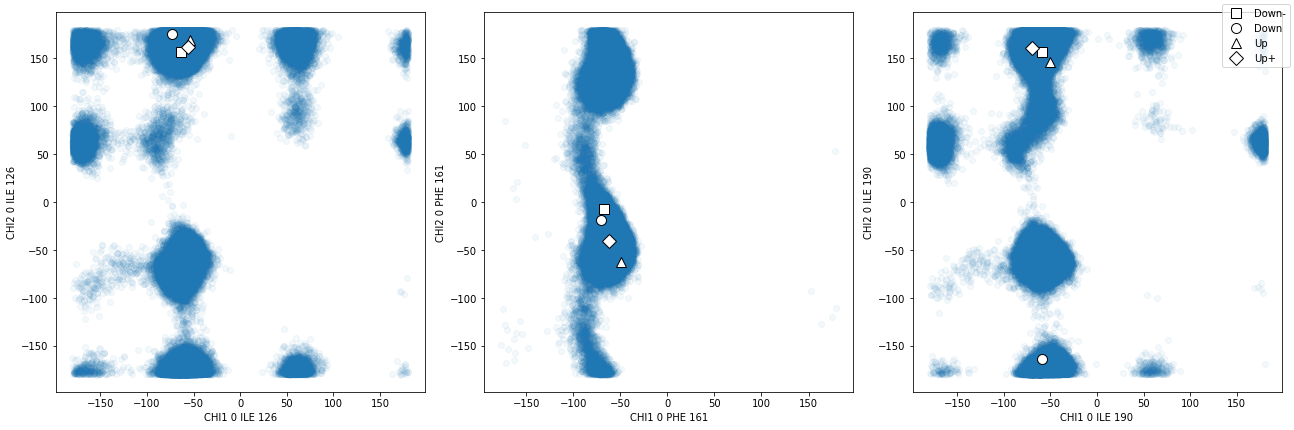

In [29]:
# convert to degrees and shift range to [0, 360)
torsions_arr = np.concatenate(hp_torsions_trajs) * 180 / np.pi
models = hp_torsions_models * 180 / np.pi
f, axes = plt.subplots(1, 3, figsize=(18, 6))
s = 10
for i in range(3):
    axes[i].scatter(torsions_arr[::s, i * 2], torsions_arr[::s, i * 2 + 1], alpha=0.05)
    axes[i].set(
        xlabel=hp_torsions.describe()[i * 2], ylabel=hp_torsions.describe()[i * 2 + 1]
    )
    plot_models(axes[i], models[:, i * 2 : i * 2 + 2])
f.legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()

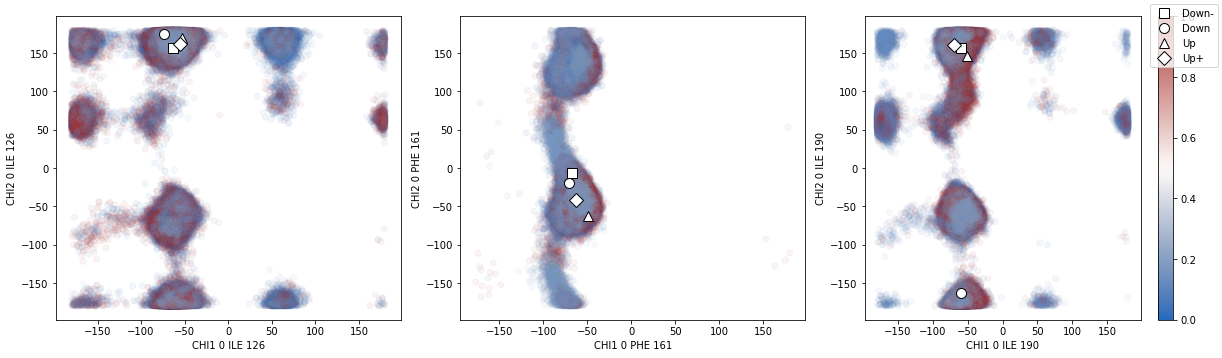

In [30]:
# plot committors against torsions
q = np.load("../../data/feat5_tica_ind1000_du/q_downup.npy", allow_pickle=True)[
    7
]  # 20 ns lag
q_arr = np.concatenate(q)

f, axes = plt.subplots(1, 3, figsize=(17, 5))

for i in range(3):
    h = axes[i].scatter(
        torsions_arr[::s, i * 2],
        torsions_arr[::s, i * 2 + 1],
        c=q_arr[::s],
        cmap="vlag",
        alpha=0.05,
    )
    axes[i].set(
        xlabel=hp_torsions.describe()[i * 2], ylabel=hp_torsions.describe()[i * 2 + 1]
    )
    plot_models(axes[i], hp_torsions_models[:, i * 2 : i * 2 + 2] * 180 / np.pi)
cb = plt.colorbar(h, ax=axes[2])
cb.solids.set(alpha=1)
f.legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()

# Sensing charges (arginines)

Suggested by Li et al. 2014

See, https://www-nature-com.proxy.uchicago.edu/articles/nsmb.2768/figures/12

In [31]:
# all sidechain torsions for arginines
arg_tors = pyemma.coordinates.featurizer("../../civsd-pro.pdb")
for r in (217, 223, 226, 229, 232):
    arg_tors.add_sidechain_torsions(f"residue {r}", deg=False, which="all")
arg_tors.describe()

['CHI1 0 ARG 217',
 'CHI2 0 ARG 217',
 'CHI3 0 ARG 217',
 'CHI4 0 ARG 217',
 'CHI5 0 ARG 217',
 'CHI1 0 ARG 223',
 'CHI2 0 ARG 223',
 'CHI3 0 ARG 223',
 'CHI4 0 ARG 223',
 'CHI5 0 ARG 223',
 'CHI1 0 ARG 226',
 'CHI2 0 ARG 226',
 'CHI3 0 ARG 226',
 'CHI4 0 ARG 226',
 'CHI5 0 ARG 226',
 'CHI1 0 ARG 229',
 'CHI2 0 ARG 229',
 'CHI3 0 ARG 229',
 'CHI4 0 ARG 229',
 'CHI5 0 ARG 229',
 'CHI1 0 ARG 232',
 'CHI2 0 ARG 232',
 'CHI3 0 ARG 232',
 'CHI4 0 ARG 232',
 'CHI5 0 ARG 232']

In [32]:
# arg_tors_trajs = pyemma.coordinates.load(xtcs, features=arg_tors, chunksize=24)
# np.save("../../data/raw_feat/arg_torsions.npy", arg_tors_trajs)

KeyboardInterrupt: 

In [33]:
arg_tors_trajs = np.load("../../data/raw_feat/arg_torsions.npy", allow_pickle=True)

In [34]:
# load models
arg_tors_feat = pyemma.coordinates.featurizer(
    "../../models/MD-clustering-center/civsd-down-gc.pdb"
)
for r in (217, 223, 226, 229, 232):
    arg_tors_feat.add_sidechain_torsions(f"residue {r}", deg=False, which="all")
# tors_mod.describe()
arg_tors_models = pyemma.coordinates.load([model_file], features=arg_tors_feat)
print(arg_tors_models.shape)

(4, 25)


In [35]:
# np.save("../../data/models_centroids_arg_torsions.npy", arg_tors_models)

In [36]:
arg_tors_models = np.load("../../data/models_centroids_arg_torsions.npy")

In [37]:
from itertools import combinations
import matplotlib as mpl

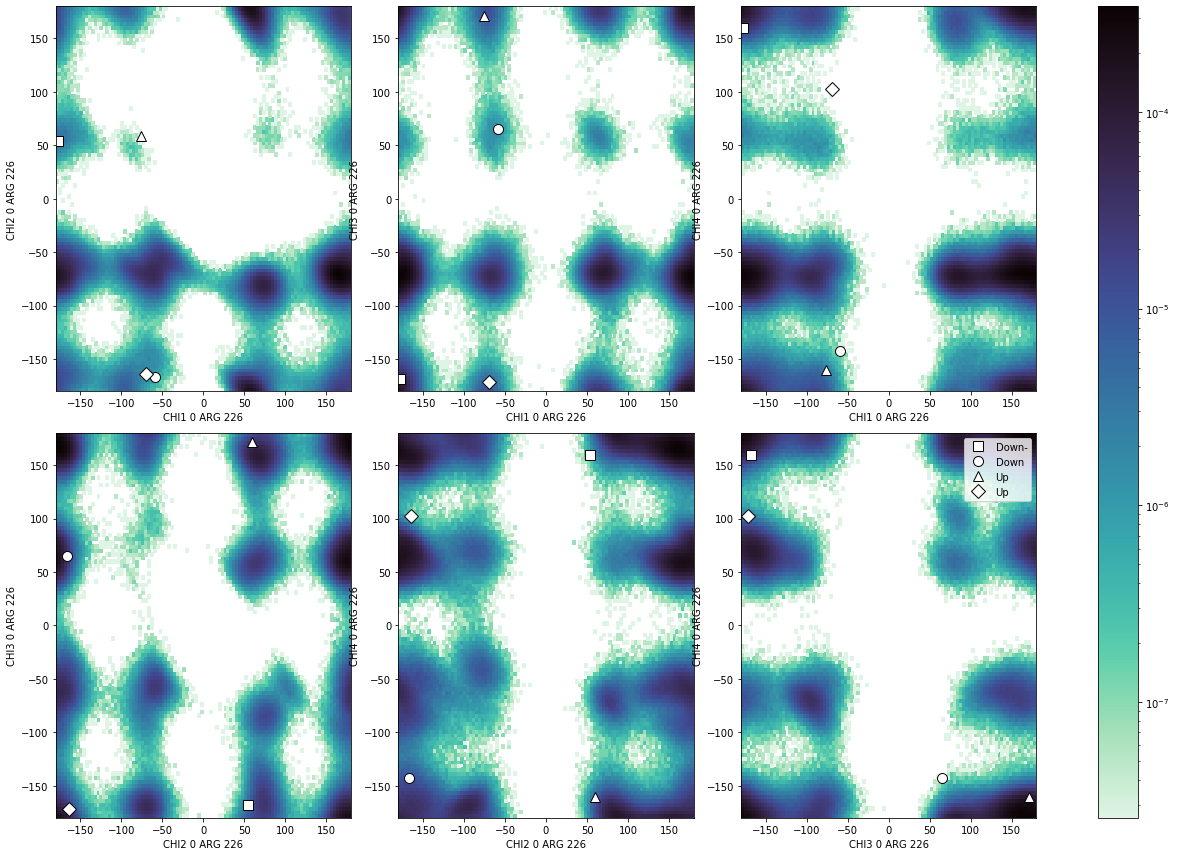

In [38]:
# for D->U transition, the R226 is the one moving through the plug
# generally care about \chi 3 and \chi 4 (near the end)
f, axes = plt.subplots(2, 3, figsize=(18, 12))
arg_tors_arr = np.concatenate(arg_tors_trajs) * 180 / np.pi
for ax, (chi_i, chi_j) in zip(axes.flat, combinations((10, 11, 12, 13), 2)):
    h, xe, ye = np.histogram2d(
        arg_tors_arr[:, chi_i], arg_tors_arr[:, chi_j], bins=100, density=True
    )
    p = ax.pcolor(xe, ye, h, cmap="mako_r", norm=mpl.colors.LogNorm())
    ax.set(xlabel=arg_tors.describe()[chi_i], ylabel=arg_tors.describe()[chi_j])
    plot_models(ax, arg_tors_models[:, [chi_i, chi_j]] * 180 / np.pi)
plt.legend(["Down-", "Down", "Up", "Up"])
f.tight_layout()
plt.colorbar(p, ax=axes.ravel().tolist())

[None]

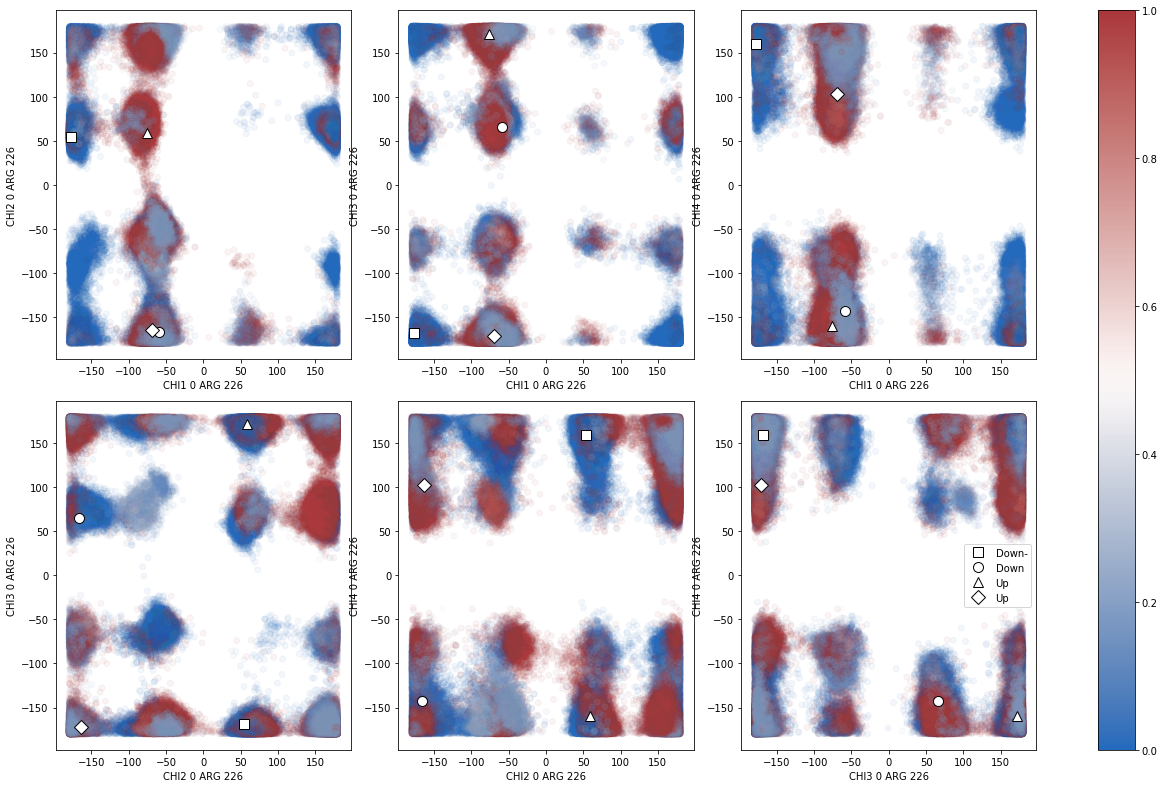

In [39]:
# for D->U transition, the R226 is the one moving through the plug
# generally care about \chi 3 and \chi 4 (near the end)
f, axes = plt.subplots(2, 3, figsize=(18, 11))

s = 10
for ax, (chi_i, chi_j) in zip(axes.flat, combinations((10, 11, 12, 13), 2)):
    h = ax.scatter(
        arg_tors_arr[::s, chi_i],
        arg_tors_arr[::s, chi_j],
        c=q_arr[::s],
        cmap="vlag",
        alpha=0.05,
    )
    ax.set(xlabel=arg_tors.describe()[chi_i], ylabel=arg_tors.describe()[chi_j])
    plot_models(ax, arg_tors_models[:, [chi_i, chi_j]] * 180 / np.pi)
plt.legend(["Down-", "Down", "Up", "Up"])
f.tight_layout()
cb = plt.colorbar(h, ax=axes.ravel().tolist())
cb.solids.set(alpha=1)

In [40]:
# plot from a trajectory near transition state
total_dq = np.empty(len(q))
for i, traj in enumerate(q):
    # squared deviation from 0.5
    total_dq[i] = np.sum((traj - 0.5) ** 2)
ts_traj_id = total_dq.argmin()
print(ts_traj_id)

121


# Analyze Committors

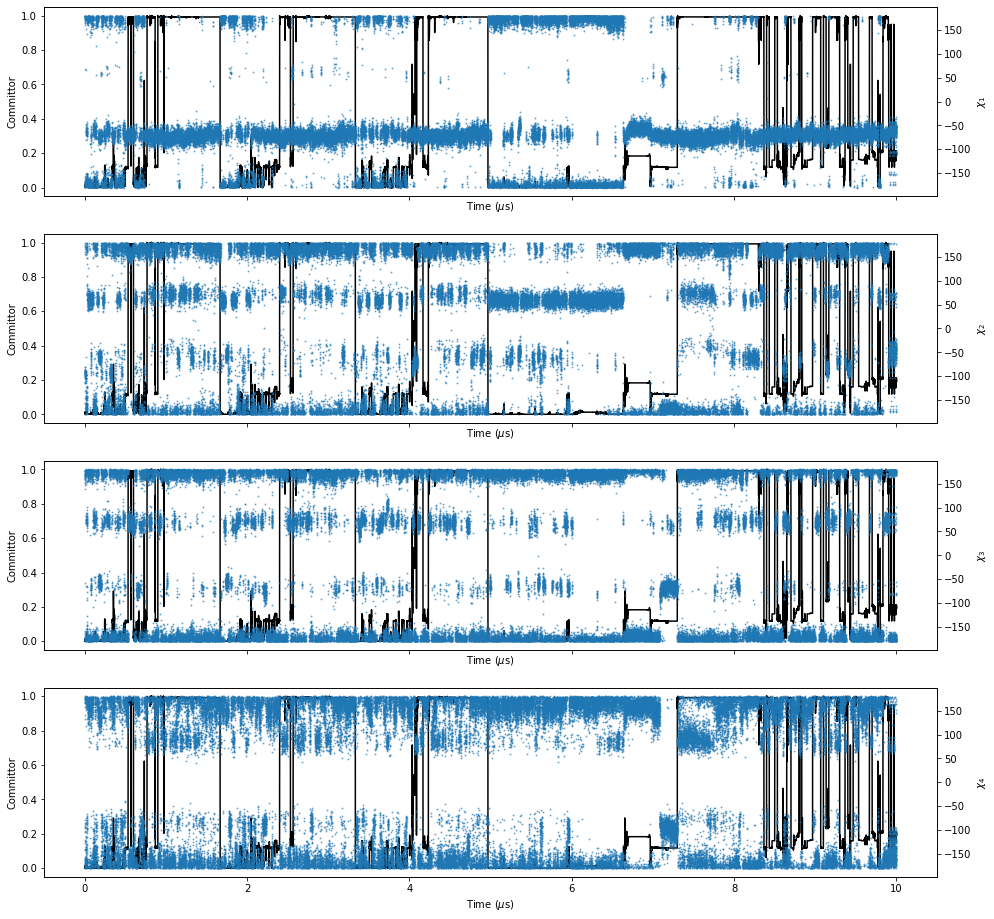

In [41]:
f, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=True)
s = 50
t = np.linspace(0, 10, len(q_arr) // s)

for i, (chi_i, ax) in enumerate(zip((10, 11, 12, 13), axes)):
    ax.plot(t, q_arr[::s], "black")
    ax.set_ylabel("Committor")
    ax.set_xlabel("Time ($\mu$s)")
    ax2 = ax.twinx()
    ax2.plot(t, arg_tors_arr[::s, chi_i], ".", lw=1, ms=2, alpha=0.5)
    ax2.set_ylabel(f"$\chi_{i + 1}$")

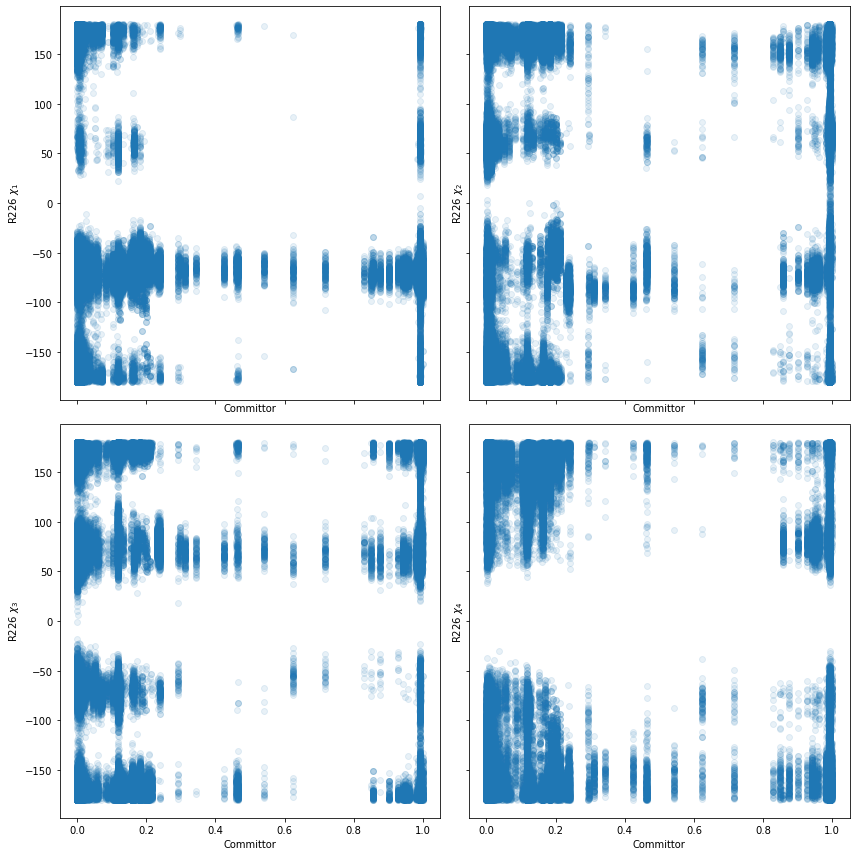

In [42]:
f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
s = 10

for i, (chi_i, ax) in enumerate(zip((10, 11, 12, 13), axes.flat)):
    ax.scatter(q_arr[::s], arg_tors_arr[::s, chi_i], alpha=0.1)
    ax.set_xlabel("Committor")
    ax.set_ylabel(f"R226 $\chi_{i + 1}$")
f.tight_layout()

# chi 1 , chi3, seem to have clear preferences at transition state

In [43]:
torsions_arr.shape

(3000000, 6)

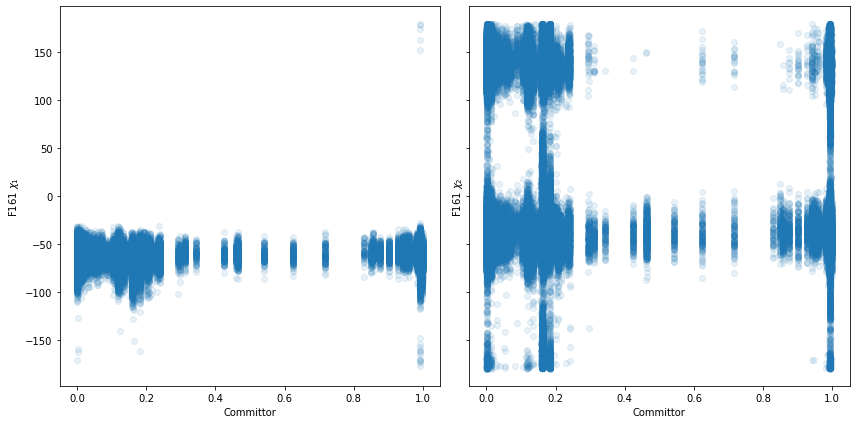

In [44]:
f, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
s = 10

# Phe 161
for i, (tors, ax) in enumerate(zip(torsions_arr[:, 2:4].T, axes)):
    ax.scatter(q_arr[::s], tors[::s], alpha=0.1)
    ax.set_xlabel("Committor")
    ax.set_ylabel(f"F161 $\chi_{i + 1}$")
f.tight_layout()

# interestingly that through the transition region, the chi_2 mostly occupies the range [-90, -20] deg

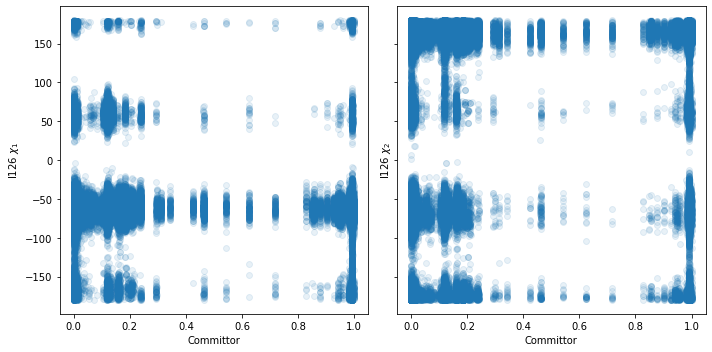

In [45]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
s = 10

# Ile 126
for i, (tors, ax) in enumerate(zip(torsions_arr[:, :2].T, axes)):
    ax.scatter(q_arr[::s], tors[::s], alpha=0.1)
    ax.set_xlabel("Committor")
    ax.set_ylabel(f"I126 $\chi_{i + 1}$")
f.tight_layout()

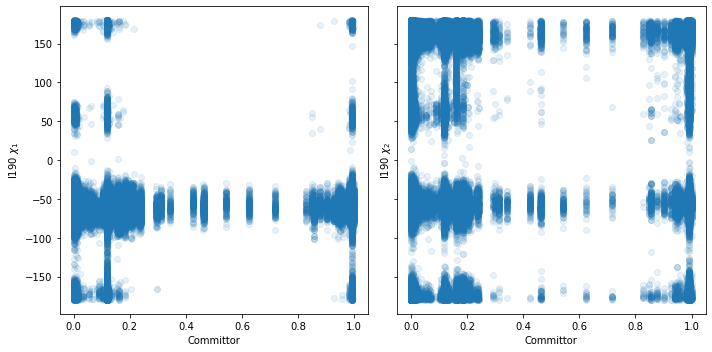

In [46]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
s = 10

# Ile 190
for i, (tors, ax) in enumerate(zip(torsions_arr[:, 4:].T, axes)):
    ax.scatter(q_arr[::s], tors[::s], alpha=0.1)
    ax.set_xlabel("Committor")
    ax.set_ylabel(f"I190 $\chi_{i + 1}$")
f.tight_layout()

In [47]:
sb_trajs = np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True)
sb_arr = np.concatenate(sb_trajs)
cv_trajs = np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
cv_arr = np.concatenate(cv_trajs)

In [48]:
sb_ids = [42, 48, 47, 53]

In [49]:
from IPython.display import display, Latex

In [50]:
ids = np.argsort((q_arr - 0.5) ** 2)
for i in ids[:10]:
    print(
        f"""{anton_frame(i)}: 
    q = {q_arr[i]:0.3f}, 
    (d, theta) = {cv_arr[i]}, SBs = {sb_arr[i, sb_ids]}, 
    (chi R226) = {arg_tors_arr[i, [10, 11, 12, 13]]}, 
    (chi2 F161) = {torsions_arr[i, 3]}
    (chi1 I190) = {torsions_arr[i, 4]}\n"""
    )

(121, 5483): 
    q = 0.465, 
    (d, theta) = [-4.121 -1.687], SBs = [0.76120234 1.5967507  0.751219   0.40483823], 
    (chi R226) = [ -74.10995   -64.537895 -159.40584   178.30078 ], 
    (chi2 F161) = -30.281810760498047
    (chi1 I190) = -55.002071380615234

(121, 9013): 
    q = 0.465, 
    (d, theta) = [-4.787  2.068], SBs = [0.7277596 1.568541  0.6477105 0.4485911], 
    (chi R226) = [ -53.55411  -66.94944 -179.47556  170.24751], 
    (chi2 F161) = -33.407901763916016
    (chi1 I190) = -60.31780242919922

(121, 9012): 
    q = 0.465, 
    (d, theta) = [-4.281  2.586], SBs = [0.6088548  1.5064868  0.68181086 0.37744674], 
    (chi R226) = [ -66.880135  -47.184124 -172.925     176.16406 ], 
    (chi2 F161) = -30.46045684814453
    (chi1 I190) = -65.48005676269531

(121, 9009): 
    q = 0.465, 
    (d, theta) = [-5.034  4.265], SBs = [0.68588483 1.5318078  0.6468949  0.39937952], 
    (chi R226) = [ -66.76344   -72.135124 -162.50987  -138.44928 ], 
    (chi2 F161) = -20.8374633789

In [51]:
for i in ids[:500]:
    if anton_frame(i)[0] != 121:
        print(
            f"""{anton_frame(i)}: 
    q = {q_arr[i]:0.3f}, 
    (d, theta) = {cv_arr[i]}, SBs = {sb_arr[i, sb_ids]}, 
    (chi R226) = {arg_tors_arr[i, [10, 11, 12, 13]]}, 
    (chi2 F161) = {torsions_arr[i, 3]}
    (chi1 I190) = {torsions_arr[i, 4]}\n"""
        )

(281, 6643): 
    q = 0.465, 
    (d, theta) = [-4.126 -2.677], SBs = [0.501781   1.4477586  0.90882015 0.49094313], 
    (chi R226) = [-159.20717   154.14365   -70.567024  155.63116 ], 
    (chi2 F161) = -77.41881561279297
    (chi1 I190) = -45.0634765625

(281, 6660): 
    q = 0.465, 
    (d, theta) = [-3.967 -8.911], SBs = [0.48827246 1.4706608  0.9256507  0.4703552 ], 
    (chi R226) = [-173.64606   154.77669   -61.222794  131.34354 ], 
    (chi2 F161) = -47.07236862182617
    (chi1 I190) = -59.21971893310547

(281, 6512): 
    q = 0.465, 
    (d, theta) = [-3.277  1.871], SBs = [0.4478268 1.3567041 1.0327144 0.4862837], 
    (chi R226) = [ -67.95232 -169.52272 -172.67944 -178.13681], 
    (chi2 F161) = -56.054866790771484
    (chi1 I190) = -67.54325103759766

(281, 6532): 
    q = 0.465, 
    (d, theta) = [-2.685 -4.922], SBs = [0.46632403 1.358542   1.0707965  0.48802546], 
    (chi R226) = [-152.8043  -175.96461  -68.44858  129.20972], 
    (chi2 F161) = -45.09081268310547
    (

## How similar is motion of ARG 229 for U->U+ transition?

In [52]:
# dga_210712_uu.ipynb
# best lag looks like 100 ns
q_uu = np.load("../../data/feat5_tica_ind1000_uu/q_downup.npy", allow_pickle=True)[9]
q_uu_arr = np.concatenate(q_uu)

[None]

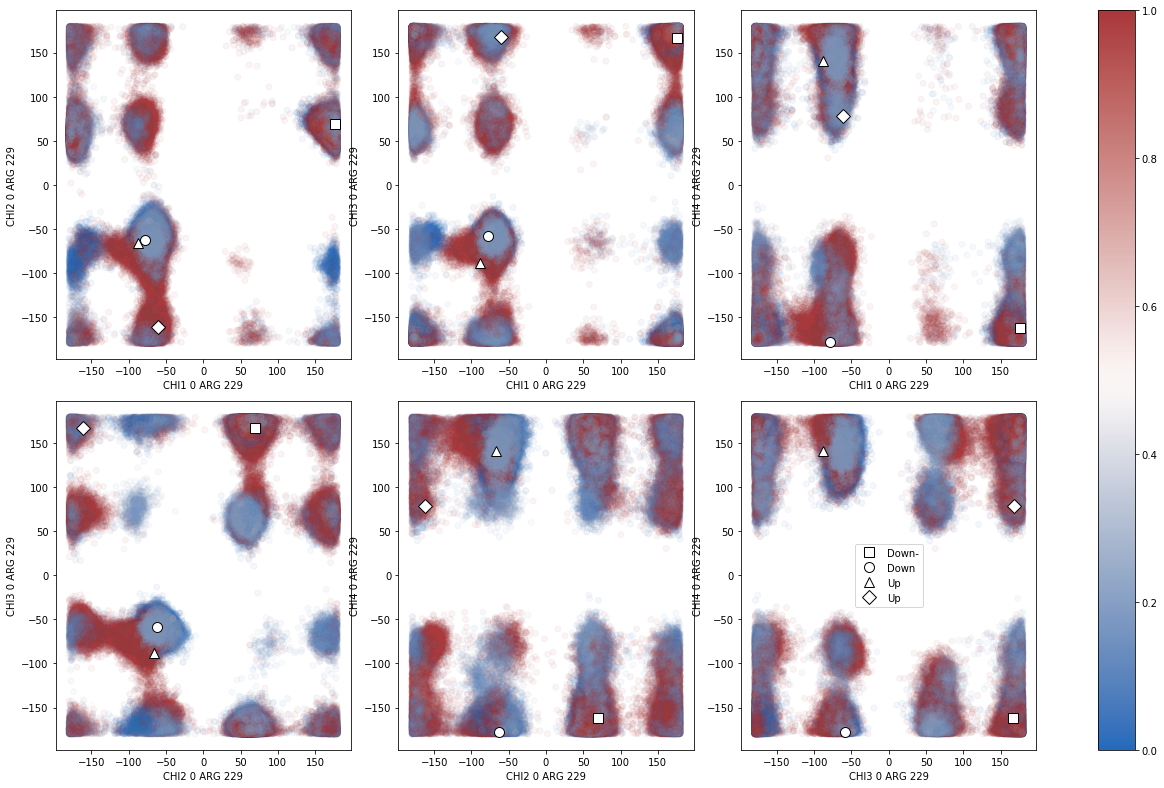

In [53]:
# for U->U+ transition, the R229 is the one moving through the plug
f, axes = plt.subplots(2, 3, figsize=(18, 11))

s = 10
for ax, (chi_i, chi_j) in zip(axes.flat, combinations((15, 16, 17, 18), 2)):
    h = ax.scatter(
        arg_tors_arr[::s, chi_i],
        arg_tors_arr[::s, chi_j],
        c=q_arr[::s],
        cmap="vlag",
        alpha=0.05,
    )
    ax.set(xlabel=arg_tors.describe()[chi_i], ylabel=arg_tors.describe()[chi_j])
    plot_models(ax, arg_tors_models[:, [chi_i, chi_j]] * 180 / np.pi)
plt.legend(["Down-", "Down", "Up", "Up"])
f.tight_layout()
cb = plt.colorbar(h, ax=axes.ravel().tolist())
cb.solids.set(alpha=1)

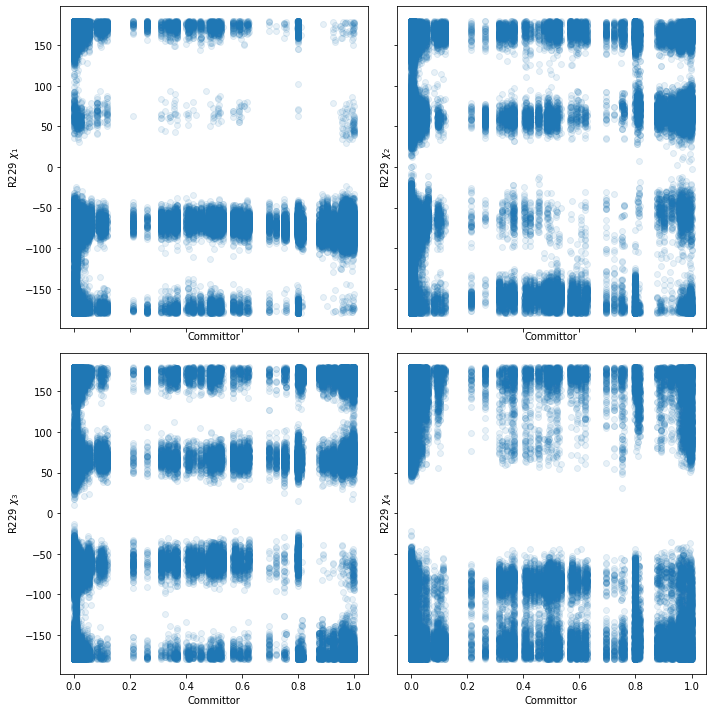

In [55]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
s = 10

for i, (chi_i, ax) in enumerate(zip((15, 16, 17, 18), axes.flat)):
    ax.scatter(q_uu_arr[::s], arg_tors_arr[::s, chi_i], alpha=0.1)
    ax.set_xlabel("Committor")
    ax.set_ylabel(f"R229 $\chi_{i + 1}$")
f.tight_layout()

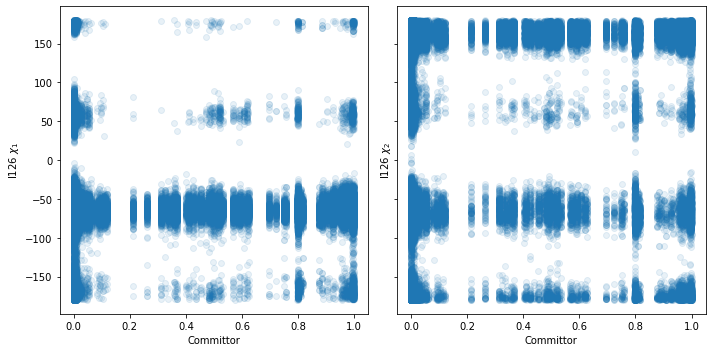

In [56]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
s = 10

# Ile 126
for i, (tors, ax) in enumerate(zip(torsions_arr[:, :2].T, axes)):
    ax.scatter(q_uu_arr[::s], tors[::s], alpha=0.1)
    ax.set_xlabel("Committor")
    ax.set_ylabel(f"I126 $\chi_{i + 1}$")
f.tight_layout()

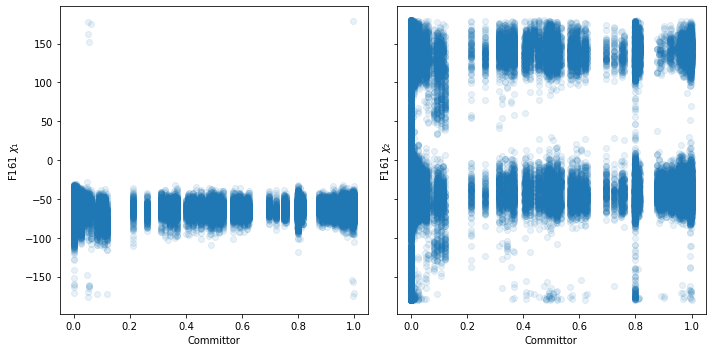

In [58]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
s = 10

# Phe 161
for i, (tors, ax) in enumerate(zip(torsions_arr[:, 2:4].T, axes)):
    ax.scatter(q_uu_arr[::s], tors[::s], alpha=0.1)
    ax.set_xlabel("Committor")
    ax.set_ylabel(f"F161 $\chi_{i + 1}$")
f.tight_layout()

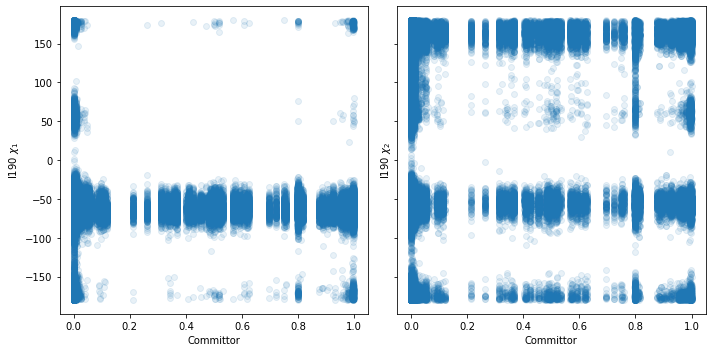

In [59]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
s = 10

# Ile 190
for i, (tors, ax) in enumerate(zip(torsions_arr[:, 4:].T, axes)):
    ax.scatter(q_uu_arr[::s], tors[::s], alpha=0.1)
    ax.set_xlabel("Committor")
    ax.set_ylabel(f"I190 $\chi_{i + 1}$")
f.tight_layout()